## In this section, I will try to implement a simple MLP and train it on the MNIST dataset.
- I will use the `pytorch` library to implement the MLP.

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

- I use the `FashionMNIST` dataset for this experiment.
- Split the dataset into training, validation and testing sets. Training set is 70% of the dataset, validation set is 20% and testing set is 10%.
 - batch size is 64.

In [3]:
# data transform
data_transform = transforms.Compose([transforms.ToTensor()])

#load data
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transform)

# split data
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset)*0.7), int(len(train_dataset)*0.3)])

# create data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



- In this simple MLP, I will use my macbook pro M3 to run the experiment. But after the experiment, I will try to run it on the GPU.
- I will use the `Adam` optimizer and the `CrossEntropyLoss` loss function.
- I will train the model for 10 epochs.
- I will use the `accuracy` metric to evaluate the model.


In [4]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

minibatch size:  64
image shape:  1 28 28
label shape:  64
tensor([7, 5, 3, 1, 9, 1, 9, 1, 0, 6, 8, 7, 5, 9, 3, 1, 2, 9, 4, 5, 4, 7, 8, 4,
        6, 0, 5, 3, 2, 5, 3, 2, 6, 3, 0, 9, 5, 2, 9, 7, 9, 9, 3, 7, 0, 4, 4, 1,
        6, 0, 8, 3, 7, 4, 3, 8, 4, 8, 7, 2, 3, 1, 7, 4])


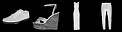

In [9]:
# check the images that I will use for this experiment
images, labels = next(iter(train_loader))
c, h, w = images[0].shape
print("minibatch size: ", len(images))
print("image shape: ", c, h, w)
print("label shape: ", len(labels))

# check the label
print(labels)

# check the image
img = torchvision.utils.make_grid(images[:4])
img = transforms.functional.to_pil_image(img)
display(img)


In [11]:
# define the model
input_size = 28*28
output_size = 10

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__() # initialize the parent class
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
model = MLP().to(device)
model

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# train the model
epochs = 10
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/10, Loss: 0.6026495695114136
Epoch 2/10, Loss: 0.3346196115016937
Epoch 3/10, Loss: 0.37666141986846924
Epoch 4/10, Loss: 0.42103877663612366
Epoch 5/10, Loss: 0.23780274391174316
Epoch 6/10, Loss: 0.40607205033302307
Epoch 7/10, Loss: 0.3137008249759674
Epoch 8/10, Loss: 0.2323542684316635
Epoch 9/10, Loss: 0.8264886736869812
Epoch 10/10, Loss: 0.2279001772403717


In [15]:
# evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the model on the 10000 test images: {100 * correct / total}%")

Accuracy of the model on the 10000 test images: 82.64%


- right now, the accuracy is 82.64%
- It's not bad, but it's not good enough.